In [30]:
import os
import sys
import time
import pickle
import numpy as np
from matplotlib import pyplot as plt, ticker
from skimage import measure, segmentation as seg, morphology as morph
from pysar.simulation.plot import *
from pysar.simulation import simulation as sim
from pysar.objects import timeseries, ifgramStack, sensor, giantTimeseries
from pysar.utils import readfile, ptime, plot as pp, writefile, utils as ut, network as pnet
import pysar.ifgram_inversion as ifginv
#from pysar.unwrap_error_phase_closure import correct_unwrap_error_closure

work_dir = os.path.expandvars('$PNOTE/sim_phaseClosure')
os.chdir(work_dir)
print('Go to directory: '+work_dir)

# reference file
proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR')
sensor_name = sensor.project_name2sensor_name(proj_dir)[0]
ts_file = os.path.join(proj_dir, 'timeseries.h5')
ts_obj = timeseries(ts_file)
ts_obj.open(print_msg=False)
ts_obj.save2bl_list_file(out_file='bl_list.txt')

tbase = np.array(ts_obj.tbase)
tbase_diff = np.diff(np.array(tbase, dtype=np.float32) / 365.25).reshape(-1, 1)
ts_sim = sim.sim_variable_timeseries(tbase, display=False)

date_list = ts_obj.dateList
dates, datevector = ptime.date_list2vector(date_list)

inc_angle = ut.incidence_angle(ts_obj.metadata, dimension=0, print_msg=False)
phase2range = -1*float(ts_obj.metadata['WAVELENGTH'])/(4.*np.pi)

# Network Setup
num_conn = 5
date12_list = pnet.select_pairs_sequential(ts_obj.dateList, num_connection=num_conn, date12_format='YYYYMMDD_YYYYMMDD')
num_ifgram = len(date12_list)
A, B = ifgramStack.get_design_matrix4timeseries(date12_list=date12_list)
C = ifgramStack.get_design_matrix4triplet(date12_list=date12_list)
print('number of ifgrams: {}'.format(num_ifgram))

## Decorrelation Noise Setup
coh_resid, decor_time = 0.0, 200  # 0.0, 50; 0.1, 50; 0.0, 200; 0.2, 200; 0.4, 200
num_sample = 100
L_max = 50
L = 3 * 9

Go to directory: /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_phaseClosure
write baseline list info to file: bl_list.txt
number of ifgrams: 475


In [31]:
## simulate interferograms without unwrapping errors
ifgram_est, coh_est = sim.simulate_network(ts_sim, date12_list, decor_time, coh_resid,
                                           L=L, num_sample=num_sample,
                                           baseline_file='bl_list.txt',
                                           sensor_name=sensor_name,
                                           inc_angle=inc_angle)[0:2]
ifgram = ifgram_est[:,0]
weight = ifginv.coherence2weight(coh_est, weight_func='var', L=L, print_msg=False)
weight_sqrt = np.sqrt(weight)
print('Done.')

Done.


In [32]:
## Simulate network of interferograms
# 1. interferograms with decorrelation noise
ifgram_err, idx_ifg_err = sim.add_unw_err2ifgram(ifgram)
ifgram_cor = correct_unwrap_error_closure(ifgram_err, C)[0].flatten()
ts_err, tcoh_err = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram_err, weight_sqrt=weight_sqrt)[0:2]
ts_cor, tcoh_cor = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram_cor, weight_sqrt=weight_sqrt)[0:2]
ts_err *= phase2range
ts_cor *= phase2range

ifgram with unwrap error: 0.1
unwrap error jump in 2*pi*(-2, 2): 
number of ifgrams with unwrap error: 47


In [9]:
## ploting functions
def plot_network(ax, date12_list, idx_ifg_err, ts_obj):
    # plot acquisitions
    ax.plot(ts_obj.times, ts_obj.pbase, 'ko', alpha=0.7, ms=6, mfc=pp.mplColors[1])
    # plot all interferometric pairs
    for date12 in date12_list:
        date1, date2 = date12.split('_')
        idx1 = ts_obj.dateList.index(date1)
        idx2 = ts_obj.dateList.index(date2)
        x = [ts_obj.times[idx1], ts_obj.times[idx2]]
        y = [ts_obj.pbase[idx1], ts_obj.pbase[idx2]]
        ax.plot(x, y, '-', lw=2, alpha=0.7, c=pp.mplColors[0])
    # plot interferometric pairs with error
    for date12 in np.array(date12_list)[idx_ifg_err]:
        date1, date2 = date12.split('_')
        idx1 = ts_obj.dateList.index(date1)
        idx2 = ts_obj.dateList.index(date2)
        x = [ts_obj.times[idx1], ts_obj.times[idx2]]
        y = [ts_obj.pbase[idx1], ts_obj.pbase[idx2]]
        ax.plot(x, y, '-', lw=2, alpha=1.0, c=pp.mplColors[1])
    # axis format
    pp.auto_adjust_xaxis_date(ax, ts_obj.times, fontsize=font_size)
    ax.set_xlabel('Time [yr]', fontsize=font_size)
    ax.set_ylabel('Perp baseline [m]', fontsize=font_size)
    return ax

def plot_ifgram_bar(ax, ifgram, ifgram_err, ifgram_cor):
    wid = 3
    num_ifgram = len(ifgram)
    x = np.arange(num_ifgram)+1 - wid/2.
    ax.bar(x, ifgram_err - ifgram, width=wid, color=pp.mplColors[1])
    ax.bar(x, ifgram_cor - ifgram, width=wid, color=pp.mplColors[0])
    # error percentage
    perc0 = np.sum(np.abs(ifgram_err - ifgram) > 0.1) / num_ifgram
    perc1 = np.sum(np.abs(ifgram_cor - ifgram) > 0.1) / num_ifgram
    # axis format
    #ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_yticks([-4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi])
    ax.set_yticklabels([r'-4$\pi$', r'-2$\pi$', '0', r'2$\pi$', r'4$\pi$'])
    ax.set_xlabel('Interferogram #', fontsize=font_size)
    ax.set_ylabel('Phase error [rad]', fontsize=font_size)
    print('Error percentage: {:.2f} -> {:.2f}'.format(perc0, perc1))
    return ax

def plot_timeseries(ax, ts_sim, ts_err, ts_cor, ts_obj):
    ax.plot(ts_obj.times, ts_sim * 100., 'k--', label='truth')
    ax.plot(ts_obj.times, ts_err * 100., 'o', mec=pp.mplColors[1], mfc='none', mew=1.5, label='before cor')
    ax.plot(ts_obj.times, ts_cor * 100., 's', color=pp.mplColors[0], alpha=0.5, label='after cor')
    pp.auto_adjust_xaxis_date(ax, ts_obj.times, fontsize=font_size)
    ax.set_xlabel('Time [yr]', fontsize=font_size)
    ax.set_ylabel('LOS displacement [cm]', fontsize=font_size)
    #ax.legend(fontsize=font_size)
    return ax

def plot_percentage(ax, pickle_files=[]):
    if not pickle_files:
        return ax
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ms = 2
    for i in range(len(pickle_files)):
        pickle_file = pickle_files[i]
        with open(pickle_file, 'rb') as f:
            ds = pickle.load(f)
        ax.plot(ds['percentage0'], ds['percentage1'], 'o', ms=2**2, color=pp.mplColors[i])
        #ax.plot(ds['percentage0'], ds['percentage1'], 'o', ms=(ms+i)**2, mfc='none', mec=pp.mplColors[i])
    ax.plot(np.array([0,1]), np.array([0,1]), 'k--')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_xlabel('Error percentage before', fontsize=font_size)
    ax.set_ylabel('Error percentage after', fontsize=font_size)
    return ax

print('Done.')

Done.


Error percentage: 0.10 -> 0.03
saved to file /Users/yunjunz/development/python/2019_RSE_PYSAR/sim_phaseClosure/err_ifgram_num.png


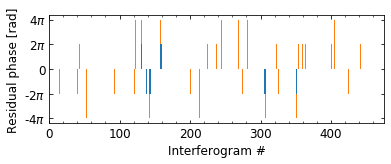

In [83]:
## Fig. 4a - unwrapping-error interferogram number before / after the correction.
fig, ax = plt.subplots(figsize=[6, 2])
wid = 1
x = np.arange(num_ifgram)+1 - wid/2.
ax.bar(x, ifgram_err - ifgram, width=wid, color=pp.mplColors[1])
ax.bar(x, ifgram_cor - ifgram, width=wid, color=pp.mplColors[0])

# axis format
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_yticks([-4*np.pi, -2*np.pi, 0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'-4$\pi$', r'-2$\pi$', '0', r'2$\pi$', r'4$\pi$'])
ax.set_xlabel('Interferogram #', fontsize=font_size)
ax.set_ylabel('Residual phase [rad]', fontsize=font_size)
ax.set_xlim(0, ifgram.shape[0])

# error percentage
perc0 = np.sum(np.abs(ifgram_err - ifgram) > 0.1) / num_ifgram
perc1 = np.sum(np.abs(ifgram_cor - ifgram) > 0.1) / num_ifgram
print('Error percentage: {:.2f} -> {:.2f}'.format(perc0, perc1))

# output
out_file = os.path.join(work_dir, 'err_ifgram_num.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file', out_file)
plt.show()

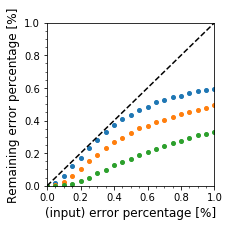

In [70]:
## Fig. 4b - performance as a function of error frequency

pfiles = ['stats_02cycle_D1_03conn.pickle', 
          'stats_02cycle_D1_05conn.pickle', 
          'stats_02cycle_D1_10conn.pickle']

fig, ax = plt.subplots(figsize=[3,3])
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ms = 2
for i in range(len(pfiles)):
    pfile = pfiles[i]
    with open(pfile, 'rb') as f:
        ds = pickle.load(f)
    ax.plot(ds['percentage0'], ds['percentage1'], 'o', ms=2**2, color=pp.mplColors[i])
    #ax.plot(ds['percentage0'], ds['percentage1'], 'o', ms=(ms+i)**2, mfc='none', mec=pp.mplColors[i])
ax.plot(np.array([0,1]), np.array([0,1]), 'k--')
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_xlabel('(input) error percentage [%]', fontsize=font_size)
ax.set_ylabel('Remaining error percentage [%]', fontsize=font_size)
plt.show()

Error percentage: 0.10 -> 0.02
saved to file sim_phase_closure.png


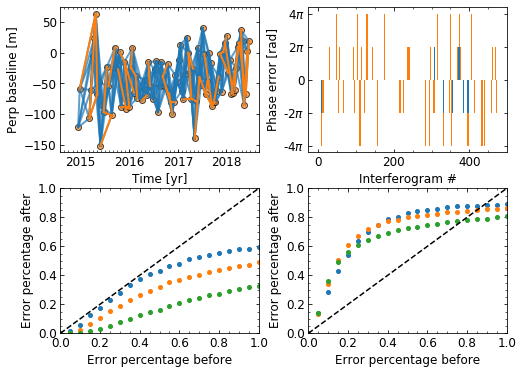

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[8, 6])
plot_network(axs[0,0], date12_list, idx_ifg_err, ts_obj)
plot_ifgram_bar(axs[0,1], ifgram, ifgram_err, ifgram_cor)
#plot_timeseries(axs[1,0], ts_sim, ts_err, ts_cor, ts_obj)
plot_percentage(axs[1,0], conn_list=[3,5,10], max_cycle=2)
plot_percentage(axs[1,1], conn_list=[3,5,10], max_cycle=10)
fig.subplots_adjust(wspace=0.25, hspace=0.25)
#fig.tight_layout()

# axis format
for ax in axs.flatten():
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)

# save
out_file = 'sim_phase_closure.png'
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file', out_file)
plt.show()

In [6]:
## Run performance
step = 0.05
Nmax = 2 # 2, 3, 5, 10
Dconstraint = True
alpha = 0.25
percentage0s = np.arange(0, 1+step, step)
for num_conn in [3]:   #[3,5,10]
    out_file = 'stats_{:02d}cycle_D{:d}_{:02d}conn.pickle'.format(Nmax, int(Dconstraint), num_conn)
    if not os.path.isfile(out_file):
        closure_performance(num_conn, Nmax, Dconstraint, alpha, step=step)

        # save to pickle file
        ds = {}
        ds['num_conn'] = num_conn
        ds['num_repeat'] = num_rep
        ds['percentage0'] = percentage0s
        ds['percentage1'] = percentage1s
        with open(out_file, 'wb') as f:
            pickle.dump(ds, f)
        print('saved to pickle file {}.'.format(out_file))
        ds = dict(ds)
    else:
        print('{} exists, skip to the next.'.format(out_file))
print('Done.')

stats_02cycle_D1_03conn.pickle exists, skip to the next.
Done.


In [42]:
step = 0.1
percentage0s = np.arange(0, 1+step, step)
percentage1_alpha1 = closure_performance(num_conn=3, Nmax=10, Dconstraint=False, alpha=0.25, step=step, num_rep=100)
percentage1_alpha0 = closure_performance(num_conn=3, Nmax=10, Dconstraint=False, alpha=0.00, step=step, num_rep=100)
print('Done.')

number of ifgrams: 193
number of triplets: 96
calculating the improvement of unw err correction for various percentage of errors ...
[==================================================]   10s /     1s 
number of ifgrams: 193
number of triplets: 96
calculating the improvement of unw err correction for various percentage of errors ...
[==================================================]    6s /     0s 
Done.


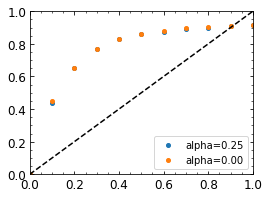

In [43]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[4, 3])
ax.plot(percentage0s, percentage1_alpha1, 'o', ms=2**2, color=pp.mplColors[0], label='alpha=0.25')
ax.plot(percentage0s, percentage1_alpha0, 'o', ms=2**2, color=pp.mplColors[1], label='alpha=0.00')

ax.plot(np.array([0,1]), np.array([0,1]), 'k--')
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
plt.legend()
# save
#out_file = 'plot_stats_{:02d}cycle_D{:d}.png'.format(Nmax, int(D))
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
#print('saved to file', out_file)
plt.show()

In [80]:
from scipy import linalg
def correct_unwrap_error_closure(ifgram, C, Dconstraint=True, thres=0.02, alpha=0.25, rcond=1e-5):
    """Estimate unwrapping error from a stack of unwrapped interferometric phase
    Parameters: ifgram : 2D np.array in size of (num_ifgram, num_pixel) of unwrap phase
                C      : 2D np.array in size of (num_triangle, num_ifgram) triangle design matrix
                Dconstraint : bool, apply zero phase jump constraint on ifgrams without unwrapping error.
                    This is disabled in fast option
                thres  : float, threshold of non-zero phase closure beyond which indicates unwrap error
                alpha  : float, Tikhonov factor, regularization parameter
                rcond  : float, cut-off value for least square estimation
    Returns:    ifgram_cor : 2D np.array in size of (num_ifgram, num_pixel) of unwrap phase after correction
                U          : 2D np.array in size of (num_ifgram, num_pixel) of phase jump integer
    Example:    ifgram_cor, U = estimate_unwrap_error(ifgram, C)
    """
    num_tri, num_ifgram = C.shape
    ifgram = ifgram.reshape(num_ifgram, -1)

    # integer ambiguity of the closure phase
    closure_pha = np.dot(C, ifgram)
    closure_int = closure_pha - ut.wrap(closure_pha)

    # prepare design matrix
    A = np.array(-1.*C, dtype=np.float32)
    I = np.eye(num_ifgram, dtype=np.float32)
    # Opt 1. Constraint on "unwrapping-error free" interferograms
    if Dconstraint:
        idx_nonzero = (closure_int >= thres).flatten()
        idx_ifgram = np.sum(C[idx_nonzero, :] != 0., axis=0) == 0.
        D = I[idx_ifgram, :]
        A = np.vstack((A, D))

    # Opt 2. Tikhonov regularization (alpha*D0) to solve equation in ill-posed scenario:
    # e.g.: network is not dense enough AND a lot of unwrapping error exist,
    # then A.shape[0] < A.shape[1]: number of unknown > number of observations
    A = np.vstack((A, alpha*I))

    # Eq 4.4 (Fattahi, 2015)
    U = np.zeros(ifgram.shape, np.float32)
    try:
        A_inv = linalg.pinv2(A, rcond=rcond)
        L = np.zeros((A.shape[0], ifgram.shape[1]), np.float32)
        L[0:num_tri, :] = closure_pha / (2.*np.pi)  #this gives better result than minimizing closure_int
        U = np.round(np.dot(A_inv, L))
    except linalg.LinAlgError:
        pass

    ifgram_cor = ifgram + 2*np.pi*U
    return ifgram_cor, U

def closure_performance(num_conn=3, Nmax=2, Dconstraint=True, alpha=0.25, step=0.05, num_rep=100):
    # simulate ifgram without unw err
    #date12_list = pnet.select_pairs_sequential(ts_obj.dateList, num_connection=num_conn, date12_format='YYYYMMDD_YYYYMMDD')
    num_ifgram = len(date12_list)
    A, B = ifgramStack.get_design_matrix4timeseries(date12_list=date12_list)
    C = ifgramStack.get_design_matrix4triplet(date12_list=date12_list)
    #print('number of connections:', num_conn)
    print('number of ifgrams: {}'.format(num_ifgram))
    print('number of triplets: {}'.format(C.shape[0]))

    ifgram = sim.simulate_network(ts_sim, date12_list, decor_time, coh_resid,
                                  L=L, num_sample=1,
                                  baseline_file='bl_list.txt',
                                  sensor_name=sensor_name,
                                  inc_angle=inc_angle)[0].flatten()

    # calculate percentage change for various percentage of unw err
    print('calculating the improvement of unw err correction for various percentage of errors ...')
    percentage0s = np.arange(0, 1+step, step)
    num_step = percentage0s.shape[0]
    percentage1s = np.zeros(num_step, np.float32)
    prog_bar = ptime.progressBar(maxValue=num_step)
    for i in range(num_step):
        perc1 = 0
        for j in range(num_rep):
            ifgram_err = sim.add_unw_err2ifgram(ifgram, percentage=percentage0s[i], Nmax=Nmax, print_msg=False)[0]
            ifgram_cor = correct_unwrap_error_closure(ifgram_err, C, Dconstraint=Dconstraint, alpha=alpha)[0].flatten()
            perc1 += np.sum(np.abs(ifgram_cor - ifgram) > 0.1) / num_ifgram
        perc1 /= num_rep
        percentage1s[i] = perc1
        prog_bar.update(i+1)
    prog_bar.close()
    return percentage1s

print('Done.')

Done.


max perpendicular baseline: 146.66 m
max temporal      baseline: 84.0 days


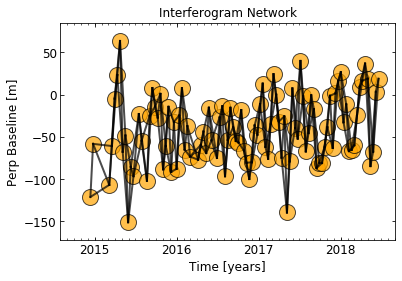

In [41]:
date12_list = pnet.select_pairs_sequential(ts_obj.dateList, num_connection=2, date12_format='YYYYMMDD_YYYYMMDD')
fig, ax = plt.subplots()
pp.plot_network(ax, date12_list, ts_obj.dateList, ts_obj.pbase)
plt.show()

In [84]:
## simple test for unwrapping error with 10 cycles